### Importing Dependencies ###

In [37]:
from keras.models import model_from_json
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

### Loading the saved model and weights ###

In [38]:
json_file = open('93.79-50epochs.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("50epochs-93.79.h5")
loaded_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Evaluating the model on test directory ###

In [39]:
test =  tf.keras.preprocessing.image_dataset_from_directory(
    'test',
    seed=1337,
    image_size= (224, 224),
    batch_size=32)
loaded_model.evaluate(test)

Found 25 files belonging to 10 classes.


2023-10-26 14:31:11.104889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type XPU is enabled.


1/1 [==============================] - 1s 591ms/step - loss: 0.3777 - accuracy: 0.9200


[0.3777124285697937, 0.9199999570846558]

### Creating a dictionary for labels ###

In [6]:
pred_dict={0:'butterfly',1:'cat',2:'chicken',3:'cow',4:'dog',5:'elephant',6:'horse',7:'sheep',8:'spider',9:'squirrel'}

### Utility function for prediction ###

In [7]:
def predict(img_array):
    predictions=loaded_model.predict(img_array)
    pred_class=predictions.argmax(axis=-1)
    return predictions,pred_class

### Predicting one clean image from the test set ###

In [27]:
img = keras.preprocessing.image.load_img('test/cat/cat1.jpg', target_size=(224, 224))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

In [28]:
#img_array=image_array(image)
prediction,pred_class= predict(img_array)
print(pred_dict[pred_class[0]],'--->',np.max(prediction*100),'%')

1/1 [==============================] - 0s 14ms/step
cat ---> 99.99991 %


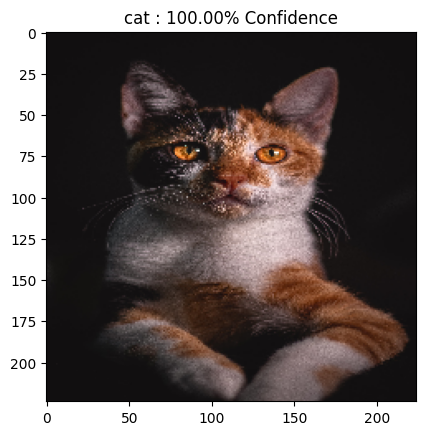

In [29]:
plt.figure()
plt.imshow(img)
plt.title('{} : {:.2f}% Confidence'.format(pred_dict[pred_class[0]], np.max(prediction*100)))
plt.show()

### Generating Adversarial on the same image ###

In [30]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = loaded_model(input_image)
    loss = loss_object(input_label, prediction)


  gradient = tape.gradient(loss, input_image)
  signed_grad = tf.sign(gradient)
  return signed_grad

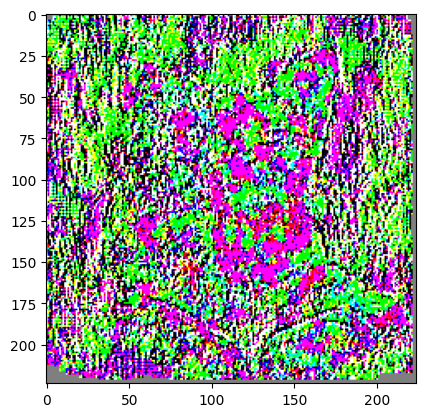

In [31]:
label=[i for i in pred_dict if pred_dict[i]=="cat"]
perturbations = create_adversarial_pattern(img_array, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [32]:
def display_images(adv_x, description,eps):
    confidences,label= predict(adv_x)
    confidence=np.max(confidences)
    label=pred_dict[label[0]]
    img1 = keras.preprocessing.image.load_img('{}.jpg'.format(eps))
    plt.figure()
    plt.imshow(img1)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description,label, confidence*100))
    plt.show()

1/1 [==============================] - 0s 13ms/step


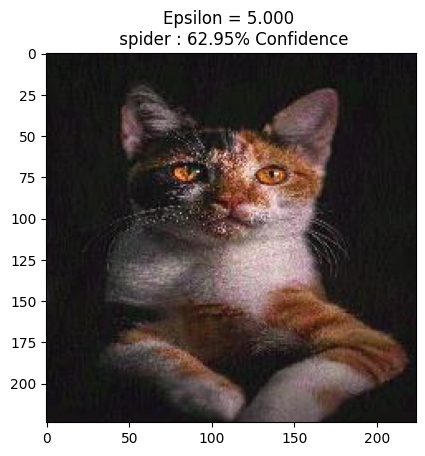

In [36]:
epsilons = [5]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = img_array + eps*perturbations
    tf.keras.preprocessing.image.save_img('{}.jpg'.format(eps),adv_x[0])
    display_images(adv_x, descriptions[i],eps)